In [1]:
%matplotlib inline

# Assuming we are in the notebooks directory, we need to move one up:
%cd ../..

/Users/olivia/Code/neural_link_SV_iDE


In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt


# Replace with directory you have downloaded NARPS data from:
DATA_DIR = './data/fMRI/event_tsvs/'


sns.set(style="ticks", palette="muted", color_codes=True, font_scale=1.8)

files = [file for file in os.listdir(DATA_DIR) if 'sub' in file]

meta_df = pd.DataFrame({'Filename': files})
meta_df.sort_values(by='Filename', inplace=True)
meta_df.reset_index(inplace=True, drop=True)
meta_df['Participant'] = 0
meta_df['Run'] = 0
meta_df['Trials Designated NoResp'] = 0
meta_df['Trials with RT == 0'] = 0
meta_df['Behaviour in File'] = True

def squash_response(row):
    if 'accept' in row:
        return 1
    elif 'reject' in row:
        return 0
    else:
        return row

def check_RT_response_data(row):
    try:
        if row['participant_response'] == 'NoResp':
            return False
    except KeyError:
        return False
    if row['RT'] == 0:
        return False
    else:
        return True

In [3]:
# These two lines are just here because we're in a notebook, so delete in .py script.
ps_df = 0
del ps_df

prev_p = 0
run_check = 0

# For each filename...
for index, row in meta_df.iterrows():
    file = row['Filename']
        
    # check the file conforms to what we think it should
    # sub-001_task-MGT_run-01_events.tsv
    # there are 4 runs per "sub" and the NARPS site says:
    # "119 healthy participants completed the experiment (n=60 from the equal indifference group and n=59 from the equal range group). Nine participants were excluded prior to fMRI analysis based on pre-registered exclusion criteria: Five did not show a significant effect of both gains and loses on their choices (Bayesian logistic regression, p < 0.05; reflecting a lack of understanding of the task) and four missed over 10% of trials (in one or more runs). Data of two additional participants is currently under QA. Thus, at least 108 participants will be included in the final dataset sent to the analysis teams (n=54 from the equal indifference group and n=54 from the equal range group)."
    
    # Check that the filenames have a certain structure:
    file_list = file.split('_')
    assert file_list[0].split('-')[0] == 'sub'
    p = int(file_list[0].split('-')[1])
    assert p > 0
    assert p <= 128
    
    assert file_list[2].split('-')[0] == 'run'
    run = int(file_list[2].split('-')[1])
    assert run > 0
    assert run <= 4
    
    # check if all participants have all 4 runs, and print who doesn't
    if prev_p != p:
        if run_check and run_check != 4:
            print(prev_p, run_check)
        run_check = 0
    prev_p = p
    run_check+=1

    # Open the file:
    p_run_df = pd.read_csv(DATA_DIR + file, delimiter='\t')

    # Create required columns for participant ID, run, and trail number:
    p_run_df['ID'] = p  # just a number 
    p_run_df['participant_id'] = file_list[0]  # the IDs the original data used
    p_run_df['run'] = run
    
    p_run_df.reset_index(inplace=True)
    p_run_df.rename(index=str, columns={"index": "trial"}, inplace=True)
    p_run_df['trial'] += 1
    
    # Risk: sqrt(gain*gain*prob_gain*(1 - prob_gain) + loss*loss*prob_loss*(1 - prob_loss))
    # based on Canessa et al 2013 https://doi.org/10.1523/JNEUROSCI.0497-13.2013
    p_run_df['risk'] =  np.sqrt((p_run_df['gain']**2 + p_run_df['loss']**2)) * 0.5
        
    p_run_df['use'] = p_run_df.apply(check_RT_response_data, axis=1)

    meta_df.loc[index, 'Participant'] = p
    meta_df.loc[index, 'Run'] = run


    # Find the files with RT set to 0 and note that in meta_df:
    if (p_run_df['RT'] == 0).any():
        meta_df.loc[index, 'Trials with RT == 0'] = (p_run_df['RT'] == 0).value_counts()[True]
        if 'participant_response' in p_run_df.columns:
            meta_df.loc[index, 'Trials Designated NoResp'] = (p_run_df['participant_response'] == 'NoResp').value_counts()[True]
        else:
            meta_df.loc[index, 'Behaviour in File'] = False    
    
    # Create accept column for participant:        
    try:
        p_run_df['accept'] = p_run_df['participant_response'].apply(squash_response)
    except KeyError:
        p_run_df['accept'] = 'NoResp'

    # Create big dataframe for all participants:
    try:
        ps_df = pd.concat([ps_df, p_run_df], sort=False)
    except NameError:
        ps_df = p_run_df
    
    ps_df

participants_df = pd.read_csv(DATA_DIR + 'participants.tsv', delimiter='\t')
ps_df = ps_df.set_index('participant_id').join(participants_df.set_index('participant_id'))

48 2


In [4]:
meta_df.head(10)

,Filename,Participant,Run,Trials Designated NoResp,Trials with RT == 0,Behaviour in File
0,sub-001_task-MGT_run-01_events.tsv,1,1,1,1,True
1,sub-001_task-MGT_run-02_events.tsv,1,2,0,0,True
2,sub-001_task-MGT_run-03_events.tsv,1,3,0,0,True
3,sub-001_task-MGT_run-04_events.tsv,1,4,0,0,True
4,sub-002_task-MGT_run-01_events.tsv,2,1,0,0,True
5,sub-002_task-MGT_run-02_events.tsv,2,2,0,0,True
6,sub-002_task-MGT_run-03_events.tsv,2,3,0,0,True
7,sub-002_task-MGT_run-04_events.tsv,2,4,0,0,True
8,sub-003_task-MGT_run-01_events.tsv,3,1,1,1,True
9,sub-003_task-MGT_run-02_events.tsv,3,2,6,6,True


In [5]:
meta_df[meta_df['Participant'] == 48]

,Filename,Participant,Run,Trials Designated NoResp,Trials with RT == 0,Behaviour in File
160,sub-048_task-MGT_run-02_events.tsv,48,2,0,7,False
161,sub-048_task-MGT_run-03_events.tsv,48,3,0,1,False


In [6]:
meta_df[meta_df['Behaviour in File'] == False]

,Filename,Participant,Run,Trials Designated NoResp,Trials with RT == 0,Behaviour in File
160,sub-048_task-MGT_run-02_events.tsv,48,2,0,7,False
161,sub-048_task-MGT_run-03_events.tsv,48,3,0,1,False


In [7]:
ps_df[ps_df['ID'] == 48]

,trial,onset,duration,gain,loss,RT,participant_response,ID,run,risk,use,accept,group,gender,age
participant_id,,,,,,,,,,,,,,,
sub-048,1,4.052,4,15,6,2.369,NaN,48,2,8.077747,False,NoResp,NaN,NaN,NaN
sub-048,2,10.935,4,8,5,1.856,NaN,48,2,4.716991,False,NoResp,NaN,NaN,NaN
sub-048,3,16.432,4,18,18,2.266,NaN,48,2,12.727922,False,NoResp,NaN,NaN,NaN
sub-048,4,21.832,4,19,8,1.339,NaN,48,2,10.307764,False,NoResp,NaN,NaN,NaN
sub-048,5,27.532,4,6,7,1.855,NaN,48,2,4.609772,False,NoResp,NaN,NaN,NaN
sub-048,6,34.432,4,17,11,1.545,NaN,48,2,10.124228,False,NoResp,NaN,NaN,NaN
sub-048,7,43.533,4,17,12,3.296,NaN,48,2,10.404326,False,NoResp,NaN,NaN,NaN
sub-048,8,51.933,4,16,7,2.059,NaN,48,2,8.732125,False,NoResp,NaN,NaN,NaN
sub-048,9,60.833,4,5,17,2.061,NaN,48,2,8.860023,False,NoResp,NaN,NaN,NaN


In [8]:
len(ps_df['ID'].unique())

109

In [9]:
ps_df.describe()

,trial,onset,duration,gain,loss,RT,ID,run,risk,age
count,27776.000000,27776.000000,27776.0,27776.000000,27776.000000,27776.000000,27776.000000,27776.000000,27776.000000,27648.000000
mean,32.500000,222.621231,4.0,18.720874,12.499712,1.632113,62.654378,2.500000,11.704670,25.546296
std,18.473286,128.175029,0.0,9.594243,4.609785,0.624821,35.662332,1.115991,4.243079,3.575662
min,1.000000,4.025000,4.0,5.000000,5.000000,0.000000,1.000000,1.000000,3.535534,18.000000
25%,16.750000,111.333500,4.0,11.000000,8.750000,1.146000,33.000000,2.000000,8.602325,23.000000
50%,32.500000,222.732000,4.0,16.000000,12.500000,1.544000,62.000000,2.500000,10.816654,25.000000
75%,48.250000,333.432000,4.0,24.000000,16.250000,1.960000,93.000000,3.000000,14.212670,27.000000
max,64.000000,441.062000,4.0,40.000000,20.000000,3.959000,124.000000,4.000000,22.360680,37.000000


In [10]:
# remove the trials where something went wrong, RT == 0 or no data
clean_ps_df = ps_df[ps_df['use']]

In [11]:
clean_ps_df.describe()

,trial,onset,duration,gain,loss,RT,ID,run,risk,age
count,27454.000000,27454.000000,27454.0,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000
mean,32.467582,222.388892,4.0,18.750091,12.495483,1.641441,62.744846,2.501457,11.716121,25.549574
std,18.480287,128.215593,0.0,9.602375,4.609901,0.609670,35.739592,1.117825,4.245242,3.575864
min,1.000000,4.025000,4.0,5.000000,5.000000,0.001000,1.000000,1.000000,3.535534,18.000000
25%,16.000000,111.031250,4.0,11.000000,8.000000,1.147000,33.000000,2.000000,8.732125,23.000000
50%,32.000000,221.830500,4.0,17.000000,12.000000,1.544000,63.000000,3.000000,10.816654,25.000000
75%,48.000000,333.026250,4.0,24.000000,16.000000,1.962000,94.000000,4.000000,14.212670,27.000000
max,64.000000,441.062000,4.0,40.000000,20.000000,3.959000,124.000000,4.000000,22.360680,37.000000


In [12]:
clean_ps_df

,trial,onset,duration,gain,loss,RT,participant_response,ID,run,risk,use,accept,group,gender,age
participant_id,,,,,,,,,,,,,,,
sub-001,1,4.071,4,14,6,2.388,weakly_accept,1,1,7.615773,True,1,equalIndifference,M,24.0
sub-001,2,11.834,4,34,14,2.289,strongly_accept,1,1,18.384776,True,1,equalIndifference,M,24.0
sub-001,3,19.535,4,34,13,1.873,strongly_accept,1,1,18.200275,True,1,equalIndifference,M,24.0
sub-001,4,27.535,4,10,10,1.457,weakly_reject,1,1,7.071068,True,0,equalIndifference,M,24.0
sub-001,5,36.435,4,12,19,1.973,strongly_reject,1,1,11.236103,True,0,equalIndifference,M,24.0
sub-001,6,43.935,4,20,8,1.767,weakly_accept,1,1,10.770330,True,1,equalIndifference,M,24.0
sub-001,7,50.535,4,28,9,1.561,strongly_accept,1,1,14.705441,True,1,equalIndifference,M,24.0
sub-001,8,59.837,4,20,15,2.289,weakly_accept,1,1,12.500000,True,1,equalIndifference,M,24.0
sub-001,9,65.838,4,10,7,2.287,weakly_accept,1,1,6.103278,True,1,equalIndifference,M,24.0


In [13]:
clean_ps_df.groupby('ID')[['gain', 'loss']].describe()
# use this to assign to each participant what condition they are in

gain                                                        loss  \
     count       mean       std   min    25%   50%    75%   max  count   
ID                                                                       
1    255.0  24.949020  9.219616  10.0  17.00  24.0  32.00  40.0  255.0   
2    256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
3    246.0  25.065041  9.278670  10.0  18.00  25.0  34.00  40.0  246.0   
4    252.0  12.484127  4.608556   5.0   8.75  12.0  16.00  20.0  252.0   
5    256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
6    256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
8    256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
9    255.0  25.035294  9.238460  10.0  18.00  26.0  33.00  40.0  255.0   
10   252.0  12.488095  4.645593   5.0   8.00  12.5  16.25  20.0  252.0   
11   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
13   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
14   256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
15   255.0  24.972549  9.245303  10.0  17.00  24.0  33.00  40.0  255.0   
16   255.0  12.490196  4.625216   5.0   8.50  12.0  16.50  20.0  255.0   
17   255.0  24.972549  9.245303  10.0  17.00  24.0  33.00  40.0  255.0   
18   255.0  12.505882  4.626924   5.0   8.50  13.0  16.50  20.0  255.0   
19   255.0  24.972549  9.245303  10.0  17.00  24.0  33.00  40.0  255.0   
20   251.0  12.525896  4.645248   5.0   8.50  12.0  17.00  20.0  251.0   
21   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
22   255.0  12.482353  4.619230   5.0   8.50  12.0  16.00  20.0  255.0   
24   255.0  12.470588  4.603803   5.0   8.50  12.0  16.00  20.0  255.0   
25   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
26   240.0  12.650000  4.622394   5.0   9.00  13.0  17.00  20.0  240.0   
27   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
29   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
30   256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
32   255.0  12.509804  4.625216   5.0   8.50  13.0  16.50  20.0  255.0   
33   253.0  25.043478  9.254026  10.0  18.00  26.0  34.00  40.0  253.0   
35   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
36   248.0  12.564516  4.585211   5.0   9.00  13.0  16.25  20.0  248.0   
..     ...        ...       ...   ...    ...   ...    ...   ...    ...   
90   255.0  12.486275  4.622651   5.0   8.50  12.0  16.50  20.0  255.0   
92   254.0  12.484252  4.623123   5.0   8.25  12.5  16.00  20.0  254.0   
93   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
94   254.0  12.468504  4.617910   5.0   8.25  12.0  16.00  20.0  254.0   
95   251.0  24.980080  9.218004  10.0  18.00  24.0  32.00  40.0  251.0   
96   251.0  12.505976  4.653919   5.0   8.50  12.0  17.00  20.0  251.0   
98   256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
99   256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
100  252.0  12.444444  4.609976   5.0   8.00  12.0  16.00  20.0  252.0   
102  256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
103  255.0  24.956863  9.229900  10.0  17.00  24.0  32.00  40.0  255.0   
104  256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
105  256.0  25.000000  9.237604  10.0  17.50  25.0  32.50  40.0  256.0   
106  256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
107  252.0  24.920635  9.253063  10.0  16.00  24.0  32.50  40.0  252.0   
108  255.0  12.521569  4.614950   5.0   9.00  13.0  16.50  20.0  255.0   
109  252.0  25.071429  9.272053  10.0  18.00  26.0  34.00  40.0  252.0   
110  253.0  12.442688  4.597454   5.0   8.00  12.0  16.00  20.0  253.0   
112  256.0  12.500000  4.618802   5.0   8.75  12.5  16.25  20.0  256.0   
113  255.0  24.964706  9.238460  10.0  17.00  24.0  32.00  40.0  255.0   
114  256.0

In [14]:
equalIndif_df = clean_ps_df[clean_ps_df['group'] == 'equalIndifference']
equalRange_df = clean_ps_df[clean_ps_df['group'] == 'equalRange']

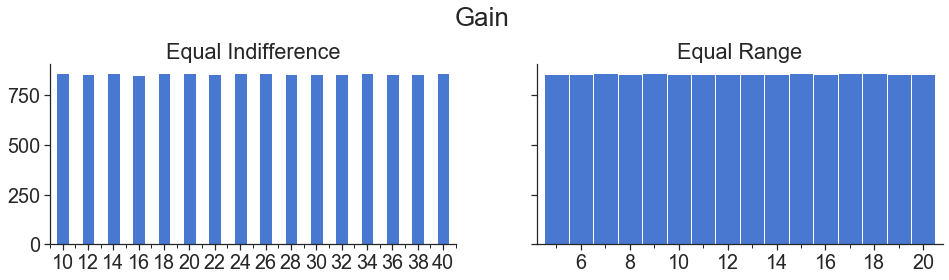

In [15]:

# sns.set()
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,4))#, tight_layout=True)
variable = 'gain'
counts = np.bincount(equalIndif_df[variable])
# print(counts)


# [print(i) for i in zip(range(len(counts)), counts)]
ticks = []
axs[0].bar(range(len(counts)), counts, width=1, align='center')
axs[0].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[0].xaxis.set_major_locator(plt.MultipleLocator(2))
# axs[0].tick_params(axis='x', which='major', labelsize=14)
axs[0].set_xlim([9,41])
axs[0].set_title('Equal Indifference')

counts = np.bincount(equalRange_df[variable])
# print(counts)
axs[1].bar(range(len(counts)), counts, width=1, align='center')
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(2))
axs[1].set_xlim([4.2,20.8])
axs[1].set_title('Equal Range')
title = fig.suptitle(variable.capitalize())

# shift subplots down:
title.set_y(0.95)
fig.subplots_adjust(top=0.75)
sns.despine(right=True)

# plt.show()

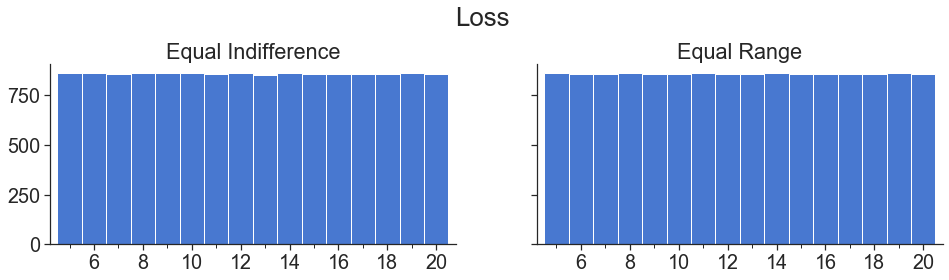

In [16]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,4))#, tight_layout=True)
variable = 'loss'
counts = np.bincount(equalIndif_df[variable])
# print(counts)


# [print(i) for i in zip(range(len(counts)), counts)]
ticks = []
axs[0].bar(range(len(counts)), counts, width=1, align='center')
axs[0].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[0].xaxis.set_major_locator(plt.MultipleLocator(2))
# axs[0].tick_params(axis='x', which='major', labelsize=14)
axs[0].set_xlim([4.2,20.8])
axs[0].set_title('Equal Indifference')

counts = np.bincount(equalRange_df[variable])
# print(counts)
axs[1].bar(range(len(counts)), counts, width=1, align='center')
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(2))
axs[1].set_xlim([4.2,20.8])
axs[1].set_title('Equal Range')
title = fig.suptitle(variable.capitalize())

# shift subplots down:
title.set_y(0.95)
fig.subplots_adjust(top=0.75)
sns.despine(right=True)

plt.show()

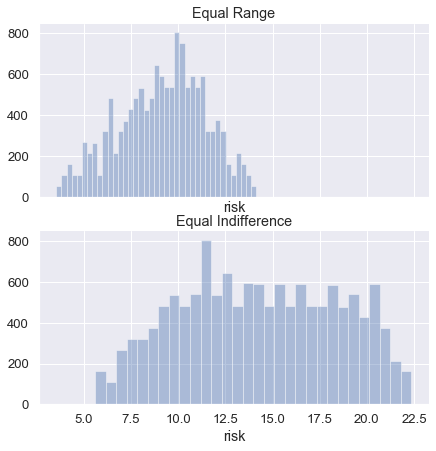

In [17]:
sns.set(font_scale=1.2)

f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
sns.despine(right=True)


sns.distplot(equalRange_df['risk'], ax=axes[0], norm_hist = False , kde=False)
sns.distplot(equalIndif_df['risk'], ax=axes[1], norm_hist = False, kde=False)
axes[0].set_title('Equal Range')
axes[1].set_title('Equal Indifference')
plt.show()

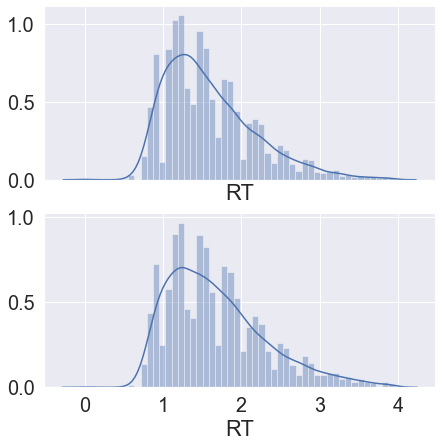

In [18]:
sns.set(font_scale=1.8)

f, axes = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
sns.despine(right=True)


sns.distplot(equalRange_df['RT'], ax=axes[0])#, kde=False)
sns.distplot(equalIndif_df['RT'], ax=axes[1])#, kde=False)
plt.show()

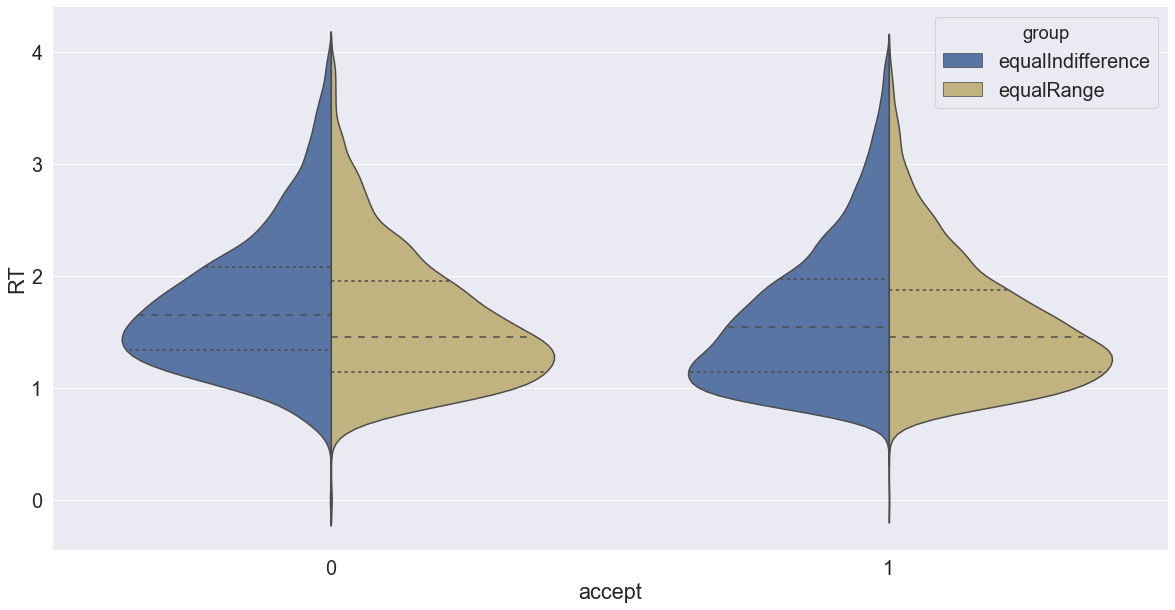

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.despine(right=True)

sns.violinplot(x="accept", y="RT", data=clean_ps_df, hue='group',
               split=True, inner="quart",
               palette={"equalRange": "y", "equalIndifference": "b"}, ax=ax)
plt.show()

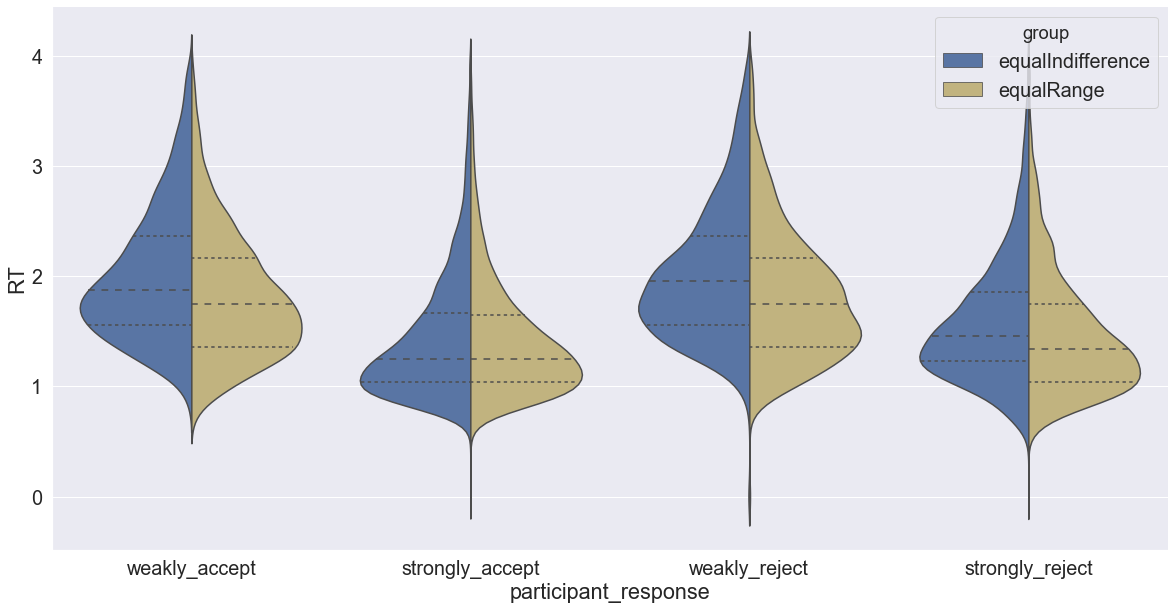

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
sns.despine(right=True)

sns.violinplot(x="participant_response", y="RT", data=clean_ps_df, hue='group',
               split=True, inner="quart",
               palette={"equalRange": "y", "equalIndifference": "b"}, ax=ax)
plt.show()

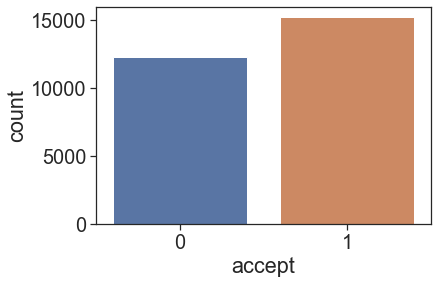

In [21]:
sns.set(font_scale=1.8)
sns.set_style('ticks')
sns.countplot(x='accept', data=clean_ps_df)
plt.show()

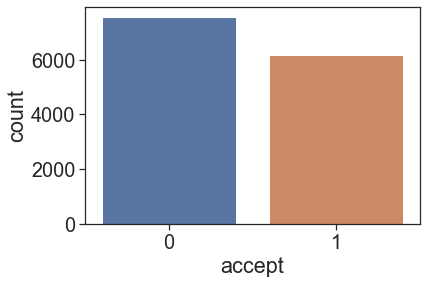

In [22]:
sns.set(font_scale=1.8)
sns.set_style('ticks')
sns.countplot(x='accept', data=equalRange_df)
plt.show()

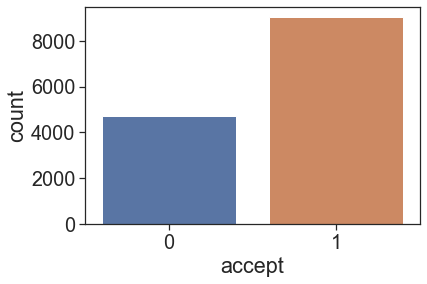

In [23]:
sns.set(font_scale=1.8)
sns.set_style('ticks')
sns.countplot(x='accept', data=equalIndif_df)
plt.show()

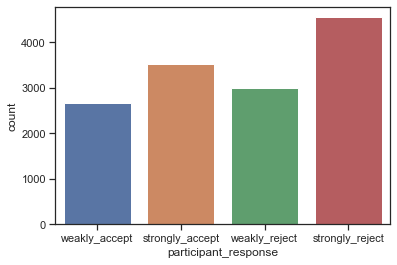

In [24]:
sns.set(font_scale=1)
sns.set_style('ticks')
sns.countplot(x='participant_response', data=equalRange_df)
plt.show()

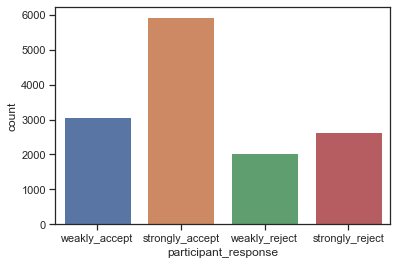

In [25]:
sns.set(font_scale=1)
sns.set_style('ticks')
sns.countplot(x='participant_response', data=equalIndif_df)
plt.show()

In [26]:
clean_ps_df.to_csv('./data/participants.csv', index=False)
meta_df.to_csv('./data/file_details.csv', index=False)

In [27]:
participants_df

,participant_id,group,gender,age
0,sub-001,equalIndifference,M,24
1,sub-002,equalRange,M,25
2,sub-003,equalIndifference,F,27
3,sub-004,equalRange,M,25
4,sub-005,equalIndifference,M,27
5,sub-006,equalRange,M,30
6,sub-008,equalRange,F,27
7,sub-009,equalIndifference,M,26
8,sub-010,equalRange,F,21
9,sub-011,equalIndifference,M,30


In [28]:
ps_df.head()

,trial,onset,duration,gain,loss,RT,participant_response,ID,run,risk,use,accept,group,gender,age
participant_id,,,,,,,,,,,,,,,
sub-001,1,4.071,4,14,6,2.388,weakly_accept,1,1,7.615773,True,1,equalIndifference,M,24.0
sub-001,2,11.834,4,34,14,2.289,strongly_accept,1,1,18.384776,True,1,equalIndifference,M,24.0
sub-001,3,19.535,4,34,13,1.873,strongly_accept,1,1,18.200275,True,1,equalIndifference,M,24.0
sub-001,4,27.535,4,10,10,1.457,weakly_reject,1,1,7.071068,True,0,equalIndifference,M,24.0
sub-001,5,36.435,4,12,19,1.973,strongly_reject,1,1,11.236103,True,0,equalIndifference,M,24.0


In [29]:
subject_13 = ps_df[ps_df['ID'] == 13]

In [30]:
subject_13['accept'].describe()

count     256
unique      2
top         1
freq      226
Name: accept, dtype: int64

In [31]:
subject_13

,trial,onset,duration,gain,loss,RT,participant_response,ID,run,risk,use,accept,group,gender,age
participant_id,,,,,,,,,,,,,,,
sub-013,1,4.065,4,28,5,0.935,strongly_accept,13,1,14.221463,True,1,equalIndifference,M,26.0
sub-013,2,9.734,4,38,6,0.833,strongly_accept,13,1,19.235384,True,1,equalIndifference,M,26.0
sub-013,3,17.936,4,40,18,0.833,strongly_accept,13,1,21.931712,True,1,equalIndifference,M,26.0
sub-013,4,24.628,4,28,17,1.145,strongly_accept,13,1,16.378339,True,1,equalIndifference,M,26.0
sub-013,5,29.628,4,16,16,2.080,strongly_accept,13,1,11.313708,True,1,equalIndifference,M,26.0
sub-013,6,35.228,4,14,14,1.352,strongly_accept,13,1,9.899495,True,1,equalIndifference,M,26.0
sub-013,7,44.128,4,20,9,0.936,strongly_accept,13,1,10.965856,True,1,equalIndifference,M,26.0
sub-013,8,53.828,4,34,13,0.937,strongly_accept,13,1,18.200275,True,1,equalIndifference,M,26.0
sub-013,9,59.629,4,16,17,1.041,strongly_reject,13,1,11.672618,True,0,equalIndifference,M,26.0


In [32]:
group_assignments = ps_df.drop_duplicates(subset='ID')[['group', 'ID']]

In [33]:
def check_group(row):
    one_group = []
    other_group = []
    if row['ID'] % 2:
        if row['group'] == 'equalIndifference':
            return True
    else:
        if row['group'] == 'equalRange':
            return True
    return False

group_assignments['consistent'] = group_assignments.apply(check_group, axis=1)
    

In [34]:
group_assignments.iloc[30:50]

,group,ID,consistent
participant_id,,,
sub-037,equalIndifference,37,True
sub-038,equalRange,38,True
sub-039,equalIndifference,39,True
sub-040,equalRange,40,True
sub-041,equalIndifference,41,True
sub-043,equalIndifference,43,True
sub-044,equalRange,44,True
sub-045,equalIndifference,45,True
sub-046,equalRange,46,True


In [35]:
group_assignments

,group,ID,consistent
participant_id,,,
sub-001,equalIndifference,1,True
sub-002,equalRange,2,True
sub-003,equalIndifference,3,True
sub-004,equalRange,4,True
sub-005,equalIndifference,5,True
sub-006,equalRange,6,True
sub-008,equalRange,8,True
sub-009,equalIndifference,9,True
sub-010,equalRange,10,True


In [36]:
group_assignments[group_assignments['consistent'] == False]

,group,ID,consistent
participant_id,,,
sub-048,NaN,48,False


In [37]:
group_assignments[['consistent']] == False

,consistent
participant_id,
sub-001,False
sub-002,False
sub-003,False
sub-004,False
sub-005,False
sub-006,False
sub-008,False
sub-009,False
sub-010,False


In [38]:
subject_87 = ps_df[ps_df['ID'] == 87]

In [39]:
subject_87

,trial,onset,duration,gain,loss,RT,participant_response,ID,run,risk,use,accept,group,gender,age
participant_id,,,,,,,,,,,,,,,
sub-087,1,4.050,4,32,14,2.983,weakly_accept,87,1,17.464249,True,1,equalIndifference,F,22.0
sub-087,2,10.130,4,38,14,2.471,weakly_accept,87,1,20.248457,True,1,equalIndifference,F,22.0
sub-087,3,16.630,4,10,18,2.058,strongly_reject,87,1,10.295630,True,0,equalIndifference,F,22.0
sub-087,4,21.730,4,32,12,1.649,weakly_accept,87,1,17.088007,True,1,equalIndifference,F,22.0
sub-087,5,27.130,4,24,13,1.540,strongly_reject,87,1,13.647344,True,0,equalIndifference,F,22.0
sub-087,6,32.931,4,28,20,1.544,strongly_reject,87,1,17.204651,True,0,equalIndifference,F,22.0
sub-087,7,40.332,4,22,19,1.440,strongly_reject,87,1,14.534442,True,0,equalIndifference,F,22.0
sub-087,8,45.933,4,40,18,1.544,weakly_reject,87,1,21.931712,True,0,equalIndifference,F,22.0
sub-087,9,51.334,4,38,9,1.338,strongly_accept,87,1,19.525624,True,1,equalIndifference,F,22.0
